# Imputing data

Load the `all_data` dictionary, and `all_keys` feature list for all financial data and email word features created in [email_features](email_features.ipynb):

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle


HOME_PATH = os.path.expanduser('~')
DATA_PATH = os.path.join(HOME_PATH, 'Desktop', 'raw_data', 'ml')
dict_path = os.path.join(DATA_PATH, 'full_dataset.pkl')
keys_path = os.path.join(DATA_PATH, 'all_keys.pkl')

with open(dict_path, 'rb') as f:
    all_data = pickle.load(f)

with open(keys_path, 'rb') as f:
    all_keys = pickle.load(f)

In [2]:
from tools.feature_format import featureFormat

# Start with all features except: 'email_address'
all_keys.remove('email_address')
del all_data['TOTAL']

data = featureFormat(all_data, all_keys, sort_keys=True, keep_keys=True, remove_NaN= False)
keys, labels, features = data[:,0], data[:,1].astype(float), data[:, 2:].astype(float)
keys.shape, labels.shape, features.shape

((149,), (149,), (149, 4231))

In [3]:
from sklearn.preprocessing import Imputer

imp = Imputer(strategy='mean')
new_features = imp.fit_transform(features)
imputer_arr = np.concatenate((keys[:,None],
                              labels[:,None],
                              new_features), axis=1)

imputer_arr.shape

(149, 4233)

In [4]:
# Transform mean_array back to a data_dict
mean_data = {}

for key in keys:
    mean_data[key] = {}
    # Since 'email_address' was removed from all_keys add back here
    mean_data[key]['email_address'] = all_data[key]['email_address']
    row_i = np.argwhere(imputer_arr == key)[0][0]
    value_row = imputer_arr[row_i, 1:]
    assert len(value_row) == len(all_keys), 'lengths of value_row and in_keys don\'t match'
    for i, value in enumerate(value_row):
        mean_data[key][all_keys[i]] = float(value)

In [5]:
print type(mean_data),\
      mean_data['METTS MARK']['email_address'],\
      len(mean_data),\
      len(mean_data['METTS MARK']) 

<type 'dict'> mark.metts@enron.com 149 4233


In [6]:
from sys import getsizeof
getsizeof(mean_data)

12568

In [7]:
imputer_path = os.path.join(DATA_PATH, 'mean_data.pkl')
with open(imputer_path, 'wb') as f:
    pickle.dump(mean_data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
from sklearn.decomposition import PCA
from copy import deepcopy

# generate a plot_dict with the non_imputed out_data
data = featureFormat(all_data, all_keys, sort_keys=True, 
                     keep_keys=False, remove_NaN=True)

labels, features = data[:,0].astype(np.float16), data[:, 1:].astype(np.float32)
pca = PCA(n_components=2)
arr = pca.fit_transform(features)

plt_dict = {'title': ''}
plt_dict['array'] = arr
plt_dict['masks'] = {}
plt_dict['masks']['poi'] = {'array': (labels == 1),
                            'kwargs': {'facecolors':'none', 
                                       'edgecolors':'lightblue',
                                       'label':'Non-imputed poi'}}
plt_dict['masks']['non_poi'] = {'array': (labels == 0),
                                'kwargs': {'facecolors':'none', 
                                            'edgecolors':'lightblue',
                                            's':5,
                                            'label':'Non-imputed non_poi'}}

# generate a plot_dict with the imputed mean_data
data = featureFormat(mean_data, all_keys, sort_keys=True, 
                     keep_keys=False, remove_NaN=True)
labels, features = data[:,0].astype(np.float16), data[:, 1:].astype(np.float32)
arr = pca.fit_transform(features)

mean_dict = {'title': 'Non-imputed vs. imputed'}
mean_dict['array'] = arr
mean_dict['masks'] = {}
mean_dict['masks']['poi'] = {'array': (labels == 1),
                            'kwargs': {'facecolors':'none', 
                                       'edgecolors':'crimson',
                                       'label':'Imputed poi'}}
mean_dict['masks']['non_poi'] = {'array': (labels == 0),
                                'kwargs': {'facecolors':'none', 
                                            'edgecolors':'crimson',
                                            's':5,
                                            'label':'Imputed non_poi'}}
list_to_plot = [plt_dict, mean_dict]

In [9]:
def scatter_plotter(dict_list, rows_columns=(1,1), figsize=(7, 7)):
    """
    Takes a list of dicts and plots each.
    
    dicts should contain the following:
    'array': X, y array to be plotted
    'title': title for the array
    'masks': dicts with
                -'mask': bool index to apply
                -'kwargs': keyword arguments to apply to the mask 
    """
    r = rows_columns[0]
    c = rows_columns[1]
    plt.close('all')
    fig = plt.figure(figsize=figsize, tight_layout=True)
    for i, dicty in enumerate(dict_list):
        X = dicty['array'][:,0]
        y = dicty['array'][:,1]
        #ax = fig.add_subplot(r, c, i+1)
        ax = fig.gca()
        for key, mask in dicty['masks'].items():
            idx = mask['array']
            kwargs = mask['kwargs']
            ax.scatter(X[idx],
                       y[idx], 
                       **kwargs)
        
        title = dicty.get('title', '')
        ax.set_title(title)
        ax.legend()
    plt.show()

/Users/TRN/anaconda/envs/ml27/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


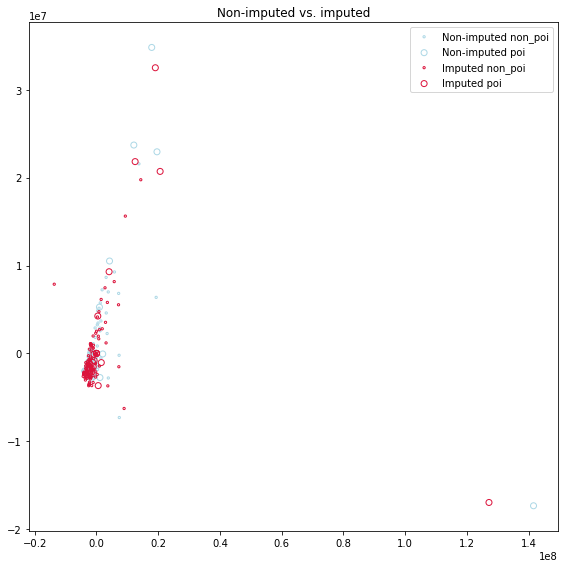

In [10]:
scatter_plotter(list_to_plot, rows_columns=(1,1), figsize=(8,8))